# Asset-centric feature engineering

## 1 Load some data for the example

Load some data from s3

In [1]:
from io import BytesIO
import boto3
import numpy as np
import pandas as pd

In [2]:
bucket_name = "cyvers-ai-datasets"
table_name = "v1/"

In [3]:
bucket = boto3.resource("s3").Bucket(bucket_name)
files = [o.key for o in bucket.objects.filter(Prefix=table_name)]
files_in_s3 = len(files)
print(f"{files_in_s3} files in s3 prefix")

161 files in s3 prefix


In [4]:
def read_file_from_s3(file_key):
    resp = bucket.Object(file_key).get()
    return pd.read_csv(
        BytesIO(resp["Body"].read()), parse_dates=["Block_Time"]
    )

In [5]:
files_to_use = [
    "v1/ChainSwap001.csv",
    "v1/Vesperi001.csv",
    "v1/Bitmart001.csv",
]

In [6]:
data = []
for f in files_to_use:
    df = read_file_from_s3(f)
    df["file_name"] = f
    data.append(df)
data = pd.concat(data, axis=0)

In [7]:
data.shape

(25955, 20)

In [8]:
data["file_name"].value_counts()

v1/Bitmart001.csv      25000
v1/ChainSwap001.csv      861
v1/Vesperi001.csv         94
Name: file_name, dtype: int64

Clean up column names

In [9]:
data.columns = (
    data.columns.str.replace("[\[\]]", "", regex=True)
    .str.replace(" ", "_", regex=False)
    .str.lower()
)

In [10]:
data["block_time"] = data["block_time"].dt.tz_localize(None)

## 2 Run full asset centric pipeline

In [11]:
from cyvers_ai_ds.features import AssetCentricFEPipeline

In [12]:
pipe = AssetCentricFEPipeline()

When invoking the execute method of the pipeline class, it returns the asset_centric features for each transaction and the asset rolling aggregation time series in the second dataframe.

In [13]:
tx_df, asset_df = pipe.execute(data)
tx_df = tx_df.merge(
    data.loc[:, ["transaction_id", "file_name"]].drop_duplicates()
)

/home/yosihammer/.conda/envs/etherscan/lib/python3.10/site-packages/cyvers_ai_ds/features/sender.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f + "_log_to_mean_ratio"] = np.log(df[f].replace(0, 1) /
/home/yosihammer/.conda/envs/etherscan/lib/python3.10/site-packages/cyvers_ai_ds/features/sender.py:133: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f + "_log_to_mean_ratio"] = np.log(df[f].replace(0, 1) /
/home/yosihammer/.conda/envs/etherscan/lib/python3.10/site-packages/cyvers_ai_ds/features/sender.py:133: Perform

In [14]:
tx_df.columns

Index(['transaction_id', 'sender_id', 'block_time', 'gas_price', 'gas_limit',
       'gas_used', 'snd_rcv_tkn_type_cnt_tx_min',
       'snd_rcv_tkn_type_cnt_tx_max', 'snd_rcv_tkn_type_cnt_tx_median',
       'snd_rcv_tkn_type_cnt_tx_mean',
       ...
       'snd_rcv_mean_time_diff_sec_tx_sum_log_to_mean_ratio',
       'amount_usd_tx_min_log_to_mean_ratio',
       'amount_usd_tx_max_log_to_mean_ratio',
       'amount_usd_tx_median_log_to_mean_ratio',
       'amount_usd_tx_mean_log_to_mean_ratio',
       'amount_usd_tx_std_log_to_mean_ratio',
       'amount_usd_tx_sum_log_to_mean_ratio',
       'receiver_type_tx_nunique_log_to_mean_ratio',
       'internal_tx_cnt_log_to_mean_ratio', 'file_name'],
      dtype='object', length=168)

In [15]:
tx_df["file_name"].value_counts()

v1/Bitmart001.csv      24916
v1/ChainSwap001.csv      694
v1/Vesperi001.csv         86
Name: file_name, dtype: int64

## 3 Visualize features in time series

In [16]:
import matplotlib.pyplot as plt

In [30]:
def plot_feature(
    tx_df,
    asset_df,
    case_name,
    asset_id,
    feature,
    from_time,
    to_time,
    ratio="log_to_median",
):
    tx_plot_df = tx_df.loc[
        tx_df["block_time"].between(from_time, to_time),
        [
            "block_time",
            "sender_id",
            feature,
            f"{feature}_{ratio}_ratio",
            "label",
        ],
    ]
    tx_plot_df["color"] = tx_plot_df["label"].map({0: "green", 1: "red"})
    asset_plot_df = asset_df.loc[
        asset_df["block_time"].between(from_time, to_time),
        [
            "sender_id",
            "block_time",
            feature + "_rolling_median",
            feature + "_rolling_qt_20",
            feature + "_rolling_qt_80",
        ],
    ]
    asset_plot_df["qt_range"] = (
        asset_plot_df[feature + "_rolling_qt_80"]
        - asset_plot_df[feature + "_rolling_qt_20"]
    )
    asset_plot_df = asset_plot_df.drop_duplicates()
    tx_plot_df = tx_plot_df.merge(asset_plot_df)
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=[12, 8])
    f.suptitle(case_name)
    ax1.scatter(
        tx_plot_df["block_time"], tx_plot_df[feature], c=tx_plot_df["color"]
    )
    ax1.set_yscale("log")
    ax1.set_ylabel(feature)
    ax1.set_xlabel("block_time")
    ax1.grid()
    ax1.plot(
        tx_plot_df["block_time"],
        tx_plot_df[feature + "_rolling_qt_20"],
        color="grey",
    )
    ax1.plot(
        tx_plot_df["block_time"],
        tx_plot_df[feature + "_rolling_qt_80"],
        color="grey",
    )
    ax1.plot(
        tx_plot_df["block_time"],
        tx_plot_df[feature + "_rolling_median"],
        color="black",
    )

    ax2.scatter(
        tx_plot_df["block_time"],
        tx_plot_df[f"{feature}_{ratio}_ratio"],
        c=tx_plot_df["color"],
    )
    ax2.set_xlabel("block_time")
    ax2.set_ylabel(f"{feature}_{ratio}_ratio")
    ax2.grid()
    return f, (ax1, ax2), tx_plot_df

In [31]:
case_name = "ChainSwap"
asset_id = "0xf3b3a0d6bcc6c0af929e1cbff56200a992a969e3"
feature = "snd_rcv_amt_usd_sum_tx_max"
from_time = pd.to_datetime("2021-02-01")
to_time = pd.to_datetime("2021-08-01")

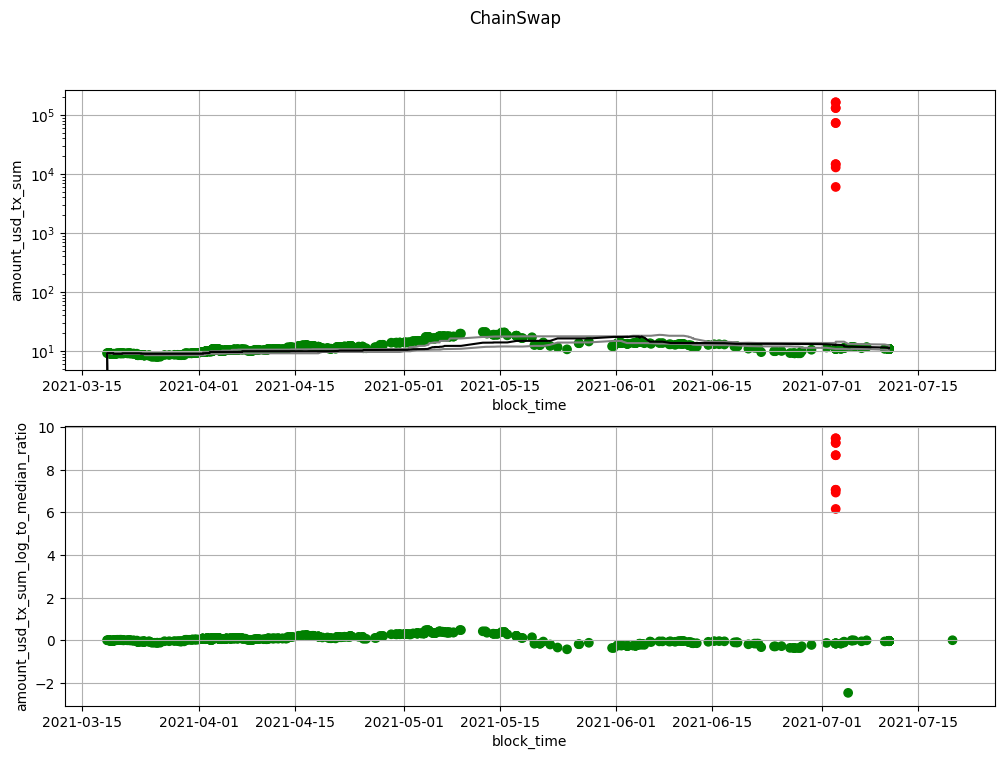

In [32]:
fig, (ax1, ax2), tx_plot_df = plot_feature(
    tx_df,
    asset_df,
    case_name="ChainSwap",
    asset_id="0xf3b3a0d6bcc6c0af929e1cbff56200a992a969e3",
    # feature="snd_rcv_amt_usd_sum_tx_max",
    feature="amount_usd_tx_sum",
    from_time=pd.to_datetime("2021-02-01"),
    to_time=pd.to_datetime("2021-08-01"),
)

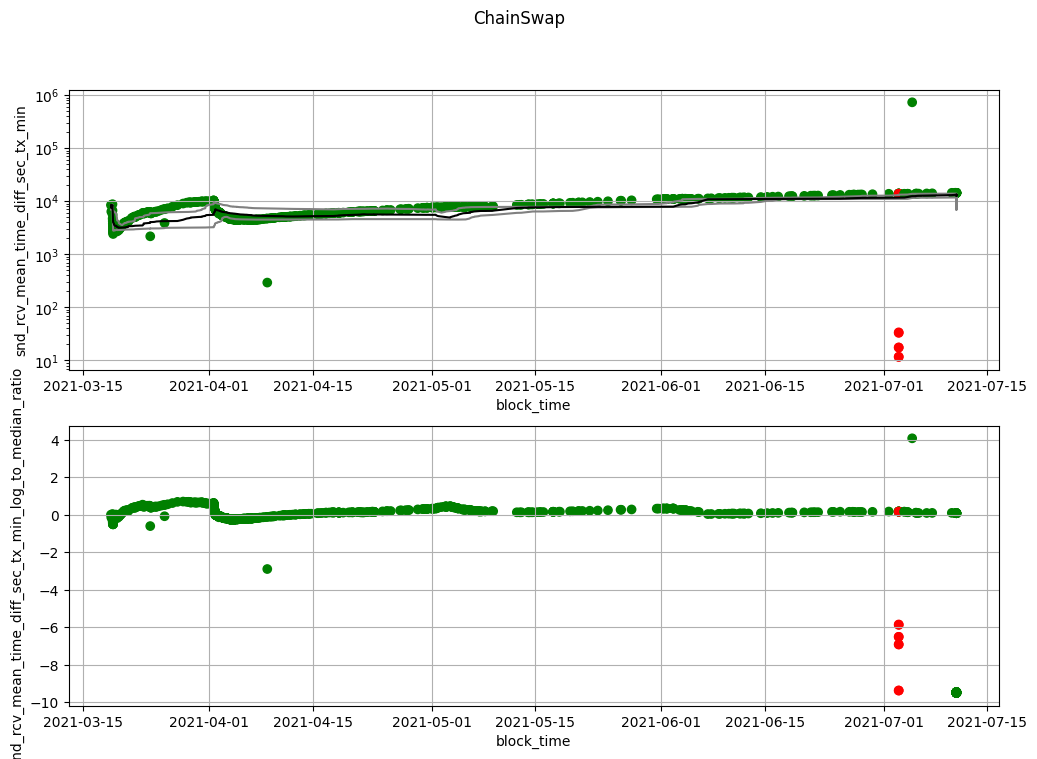

In [36]:
fig, (ax1, ax2), tx_plot_df = plot_feature(
    tx_df,
    asset_df,
    case_name="ChainSwap",
    asset_id="0xf3b3a0d6bcc6c0af929e1cbff56200a992a969e3",
    # feature="snd_rcv_amt_usd_sum_tx_max",
    feature="snd_rcv_mean_time_diff_sec_tx_min",
    from_time=pd.to_datetime("2021-02-01"),
    to_time=pd.to_datetime("2021-08-01"),
)

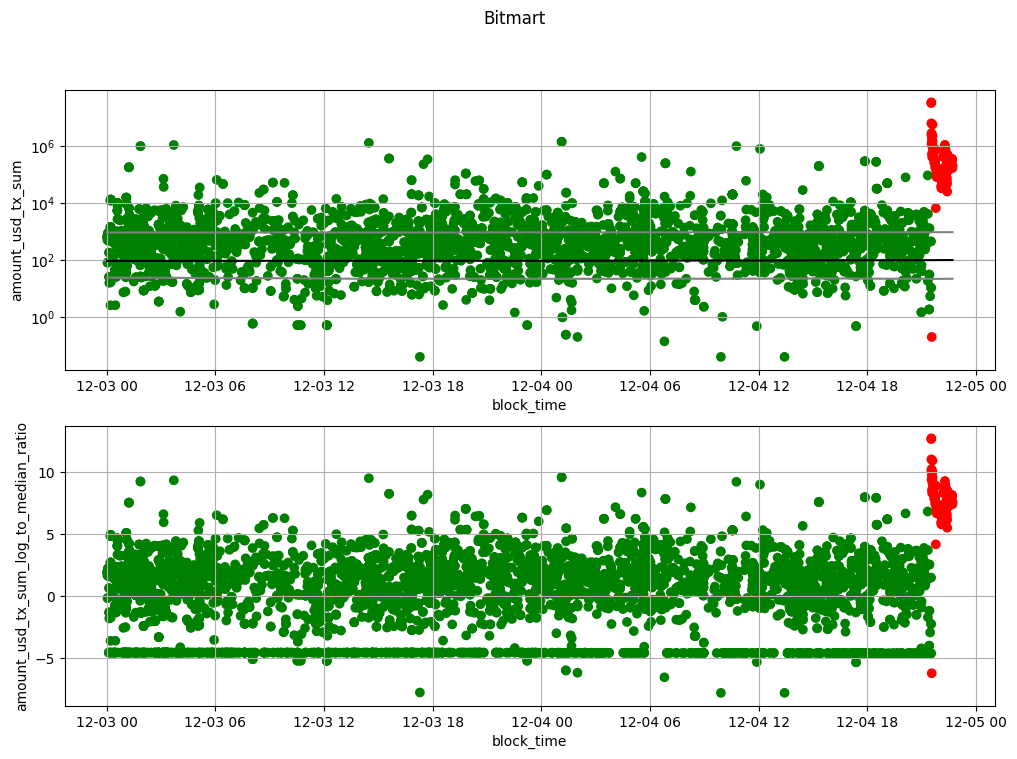

In [33]:
fig, (ax1, ax2), tx_plot_df = plot_feature(
    tx_df,
    asset_df,
    case_name="Bitmart",
    asset_id="0x68b22215ff74e3606bd5e6c1de8c2d68180c85f7",
    feature="amount_usd_tx_sum",
    # feature="snd_rcv_amt_usd_sum_tx_max",
    from_time=pd.to_datetime("2021-12-03"),
    to_time=pd.to_datetime("2021-12-05"),
)

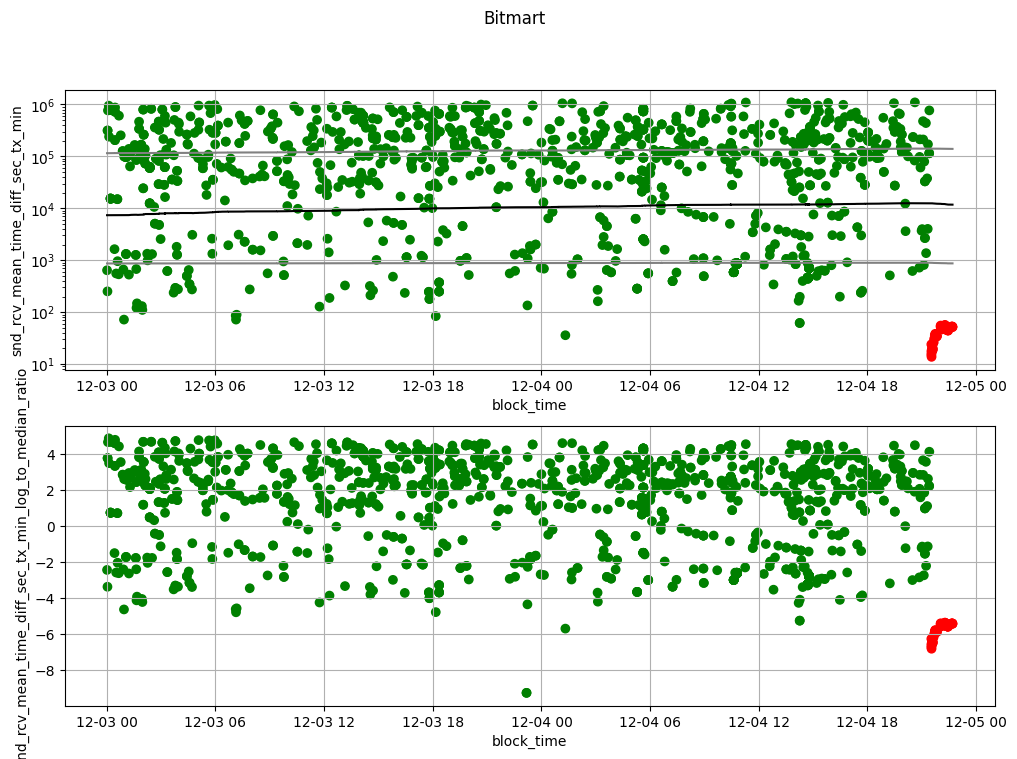

In [35]:
fig, (ax1, ax2), tx_plot_df = plot_feature(
    tx_df,
    asset_df,
    case_name="Bitmart",
    feature="snd_rcv_mean_time_diff_sec_tx_min",
    asset_id="0x68b22215ff74e3606bd5e6c1de8c2d68180c85f7",
    from_time=pd.to_datetime("2021-12-03"),
    to_time=pd.to_datetime("2021-12-05"),
)

## 3a Visualize features in time series - bokeh interactive plots

In [21]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, CrosshairTool, Span
from bokeh.layouts import column

In [22]:
output_notebook()

Loading BokehJS ...

In [23]:
def bokeh_plot_asset_ts(
    tx_df,
    asset_df,
    feature,
    asset_id=None,
    from_time=None,
    to_time=None,
    case_name="",
):
    tx_plot_df = tx_df.loc[
        :,
        ["block_time", "sender_id", feature, feature + "_log_ratio", "label"],
    ]
    tx_plot_df["color"] = tx_plot_df["label"].map({0: "green", 1: "red"})
    asset_plot_df = asset_df.loc[
        :,
        [
            "sender_id",
            "block_time",
            feature + "_rolling_median",
            feature + "_rolling_qt_20",
            feature + "_rolling_qt_80",
        ],
    ]
    asset_plot_df["qt_range"] = (
        asset_plot_df[feature + "_rolling_qt_80"]
        - asset_plot_df[feature + "_rolling_qt_20"]
    )
    asset_plot_df = asset_plot_df.drop_duplicates()
    tx_plot_df = tx_plot_df.merge(asset_plot_df)
    if asset_id is not None:
        tx_plot_df = tx_plot_df.loc[tx_plot_df["sender_id"] == asset_id, :]
        asset_plot_df = asset_plot_df.loc[
            asset_plot_df["sender_id"] == asset_id, :
        ]
    if from_time is not None:
        tx_plot_df = tx_plot_df.loc[tx_plot_df["block_time"] >= from_time, :]
        asset_plot_df = asset_plot_df.loc[
            asset_plot_df["block_time"] >= from_time, :
        ]
    if to_time is not None:
        tx_plot_df = tx_plot_df.loc[tx_plot_df["block_time"] <= to_time, :]
        asset_plot_df = asset_plot_df.loc[
            asset_plot_df["block_time"] <= to_time, :
        ]
    asset_src = ColumnDataSource(asset_plot_df)
    tx_src = ColumnDataSource(tx_plot_df)

    p1_tooltips = [
        ("asset_median", "@" + feature + "_rolling_median"),
        ("asset_low_qt", "@" + feature + "_rolling_qt_20"),
        ("asset_high_at", "@" + feature + "_rolling_qt_80"),
        ("asset_range", "@qt_range"),
        ("value", "@" + feature),
        ("ratio", "@" + feature + "_log_ratio"),
    ]
    p1 = figure(
        x_axis_type="datetime",
        y_axis_type="log",
        height=300,
        width=800,
        title=case_name,
        tooltips=p1_tooltips,
    )

    p1.scatter(x="block_time", y=feature, color="color", source=tx_src)
    p1.line(
        x="block_time",
        y=feature + "_rolling_median",
        color="black",
        source=asset_src,
        line_width=2,
    )
    p1.line(x="block_time", y=feature + "_rolling_qt_20", source=asset_src)
    p1.line(x="block_time", y=feature + "_rolling_qt_80", source=asset_src)
    p1.xaxis.axis_label = "Block Time"
    p1.yaxis.axis_label = feature

    p2 = figure(x_axis_type="datetime", height=300, width=800)
    p2.scatter(
        x="block_time",
        y=feature + "_log_ratio",
        source=tx_plot_df,
        color="color",
    )
    p2.xaxis.axis_label = "Block Time"
    p2.yaxis.axis_label = feature + "_log_ratio"
    p2.x_range = p1.x_range

    height = Span(dimension="height")
    crosshair = CrosshairTool(overlay=height)
    p1.add_tools(crosshair)
    p2.add_tools(crosshair)
    p = column([p1, p2])
    return p

In [24]:
# case_name = "ChainSwap"
# asset_id = "0xf3b3a0d6bcc6c0af929e1cbff56200a992a969e3"
# feature = "snd_rcv_amt_usd_sum_tx_max"
# from_time = pd.to_datetime("2021-02-01")
# to_time = pd.to_datetime("2021-08-01")
# p = bokeh_plot_asset_ts(
#    tx_df, asset_df, feature, asset_id, from_time, to_time, case_name=case_name
# )
# show(p)

### Bilaxy

In [25]:
# case_name = "Bitmart"
# asset_id = "0x68b22215ff74e3606bd5e6c1de8c2d68180c85f7"
# feature = "amount_usd_tx_sum"
# from_time = pd.to_datetime("2021-12-03")
# to_time = pd.to_datetime("2021-12-08")
# p = bokeh_plot_asset_ts(
#    tx_df, asset_df, feature, asset_id, from_time, to_time, case_name=case_name
# )
# show(p)

In [26]:
# feature = "snd_rcv_mean_time_diff_sec_tx_min"
# p = bokeh_plot_asset_ts(
#    tx_df, asset_df, feature, asset_id, from_time, to_time, case_name=case_name
# )
# show(p)